## Analyse ABES embeddings - 16/05/2023

Ce notebook calcule les métriques quantitatives entre laprédiction des chaines d'indexation (et concepts) par la méthode des embeddings de Christophe Bonnefond, et l'indexation du sudoc. 
Mise à jour me 26/06/2023 suite à la deuxième itération de calcul des embeddings après avoir enlevé les concepts RAMEAU qui n'étaient ni des Tf, ni des Td

# Set project

In [1]:
# Import librairies and useful functions
from sklearn.preprocessing import MultiLabelBinarizer

from utils_project import *
from utils_metrics import *
from utils_visualization import *


# Import data

In [2]:
# Original dataset
test_dataset = "test_dataset.csv"
valid100_dataset = "valid100_dataset.csv"
embedding_test = "test_dataset_resu.csv"
embedding_100notices = "valid100_resu.csv"

## Check Files

In [3]:
#  Check import of rameau concepts list
print("Nombre de notices différentes: ", ram.shape[0])
ram.head(10)

Nombre de notices différentes:  103628


PPN                                        NOM   
0  157992527                                     Kirp?n  \
1  110140494                        Militaires artistes   
2  028492161                         Militaires romains   
3  028521757                       Militaires prussiens   
4  029895561                                 Sa-skya-pa   
5  031875459                     Militaires réunionnais   
6  032370083  Construction à l'épreuve de la sécheresse   
7  032878117                      Missionnaires suisses   
8  034423982                       Militaires ivoiriens   
9  034686940                            Outils à métaux   

                              URI  
0  https://www.idref.fr/157992527  
1  https://www.idref.fr/110140494  
2  https://www.idref.fr/028492161  
3  https://www.idref.fr/028521757  
4  https://www.idref.fr/029895561  
5  https://www.idref.fr/031875459  
6  https://www.idref.fr/032370083  
7  https://www.idref.fr/032878117  
8  https://www.idref.fr/034423982  
9  https://www.idref.fr/034686940

In [4]:
# Import train dataset
df_train = pd.read_csv(os.path.join(data_path, "train_dataset.csv"))
df_train["PPN"] = df_train["PPN"].astype(str)
print("Dimension of the dataset: ", df_train.shape)

Dimension of the dataset:  (125220, 10)


In [5]:
# Import validation dataset
df_valid = pd.read_csv(os.path.join(data_path, valid100_dataset))
df_valid["PPN"] = df_valid["PPN"].astype(str)
print("Dimension of the dataset: ", df_valid.shape)

Dimension of the dataset:  (100, 10)


In [6]:
# Import test dataset
df_test = pd.read_csv(os.path.join(data_path, test_dataset))
df_test["PPN"] = df_test["PPN"].astype(str)
print("Dimension of the dataset: ", df_test.shape)

Dimension of the dataset:  (29227, 10)


In [7]:
# Import embeddings
emb_test = pd.read_csv(
    os.path.join(data_path_embed, embedding_test))
# Temporaire : remove NaN 
emb_test = emb_test.dropna()
emb_test.head(3)

ppn     score                        label
0  00002564X  0.797401    Innovation -- Philosophie
1  00002564X  0.779297  Innovation -- Aspect social
2  00002564X  0.775827   Technique -- Aspect social

## Check embeddings import

In [8]:
# Rename columns
emb_test.rename(columns={"ppn" : "PPN", "label": "embedding_chains"}, inplace=True)

# Split chains into concepts
emb_test["embeddings_autorites"] = emb_test["embedding_chains"].apply(lambda x: x.split(" -- "))
emb_test.head(20)

PPN     score                                   embedding_chains   
0   00002564X  0.797401                          Innovation -- Philosophie  \
1   00002564X  0.779297                        Innovation -- Aspect social   
2   00002564X  0.775827                         Technique -- Aspect social   
3   00002564X  0.774429                            Prévision technologique   
4   00002564X  0.773781                          Technique et civilisation   
5   00002564X  0.770500                        Philosophie de la technique   
6   000057525  0.801763                          Mathématiques économiques   
7   000057525  0.764727                                        Économétrie   
8   000057525  0.761931                              Modèles mathématiques   
9   000057525  0.759410                             Modèles économétriques   
10  000057525  0.755984                                Systèmes dynamiques   
11  000057525  0.750412                                   Théorie des jeux   
12  000079472  0.780615                                            Pétrole   
13  000079472  0.755181                             Gisements pétrolifères   
14  000079472  0.750400  Pétrole -- Industrie et commerce -- Aspect pol...   
15  000079472  0.739094  Pétrole -- Industrie et commerce -- Aspect éco...   
16  000079472  0.736307       Pétrole -- Industrie et commerce -- Histoire   
17  000079472  0.719318            Pétrole -- Réserves -- Aspect politique   
18  000085642  0.771823                                  Magie -- Histoire   
19  000085642  0.726719                                   Magie chrétienne   

                                 embeddings_autorites  
0                           [Innovation, Philosophie]  
1                         [Innovation, Aspect social]  
2                          [Technique, Aspect social]  
3                           [Prévision technologique]  
4                         [Technique et civilisation]  
5                       [Philosophie de la technique]  
6                         [Mathématiques économiques]  
7                                       [Économétrie]  
8                             [Modèles mathématiques]  
9                            [Modèles économétriques]  
10                              [Systèmes dynamiques]  
11                                 [Théorie des jeux]  
12                                          [Pétrole]  
13                           [Gisements pétrolifères]  
14  [Pétrole, Industrie et commerce, Aspect politi...  
15  [Pétrole, Industrie et commerce, Aspect économ...  
16         [Pétrole, Industrie et commerce, Histoire]  
17              [Pétrole, Réserves, Aspect politique]  
18                                  [Magie, Histoire]  
19                                 [Magie chrétienne]

In [9]:
# Check for indexation chain "Art -- Thèmes, motifs" => bad cutting 'Autority "Thème, motifs" splitted into 2 autorities
emb_test[emb_test["PPN"] == "24155859X"]

PPN     score         embedding_chains   
113706  24155859X  0.806226                 Art brut  \
113707  24155859X  0.797718                      Art   
113708  24155859X  0.793940  Expositions artistiques   
113709  24155859X  0.787193                 Artistes   
113710  24155859X  0.786264       Peinture abstraite   
113711  24155859X  0.785664    Art -- Thèmes, motifs   

             embeddings_autorites  
113706                 [Art brut]  
113707                      [Art]  
113708  [Expositions artistiques]  
113709                 [Artistes]  
113710       [Peinture abstraite]  
113711      [Art, Thèmes, motifs]

In [10]:
# Check that Thèmes, motif will be well flattened
flatten(emb_test.loc[emb_test["PPN"] == "24155859X", "embeddings_autorites"])

['Art brut',
 'Art',
 'Expositions artistiques',
 'Artistes',
 'Peinture abstraite',
 'Art',
 'Thèmes, motifs']

In [11]:
keywords = flatten(emb_test["embeddings_autorites"])
chaines = emb_test["embedding_chains"]
print(f"Le dataset contient: \n - {len(set(keywords))} autorités RAMEAU differentes \n - {len(chaines.unique())} chaines d'indexation différentes")

Le dataset contient: 
 - 14272 autorités RAMEAU differentes 
 - 27541 chaines d'indexation différentes


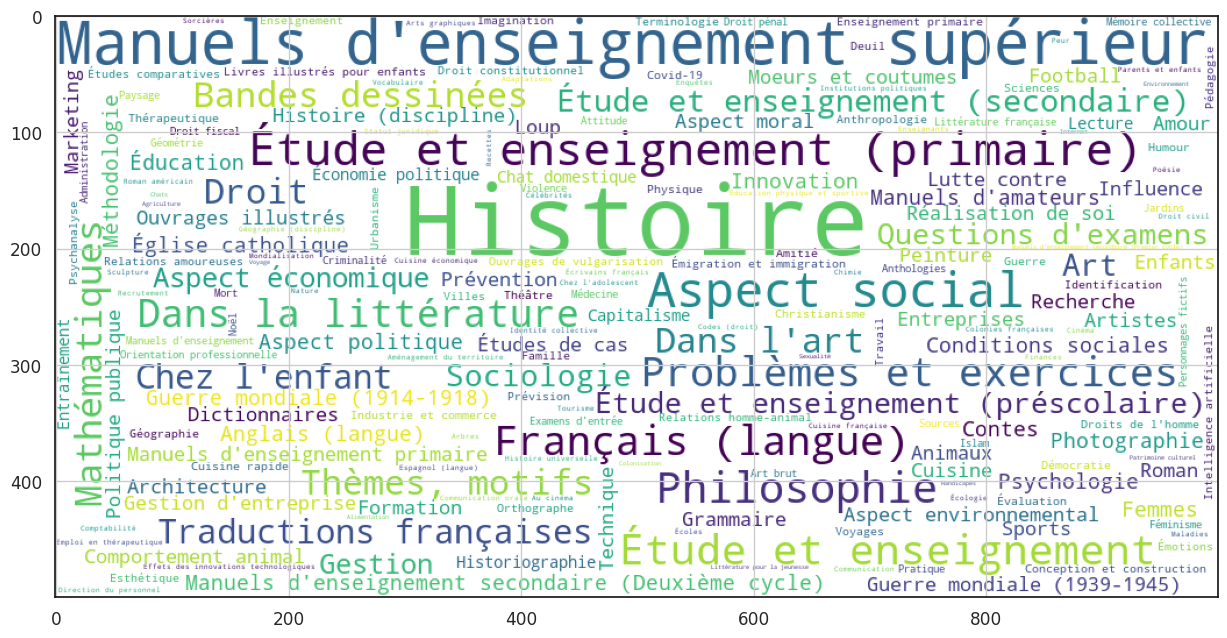

In [12]:
# Get list of labels
plot_wordcloud(
    keywords,
    backgound_color="white",
    figsize=(15, 8),
    width=1000,
    height=500,
    save_file="wordcloud_embeddings_autorites.png",
)

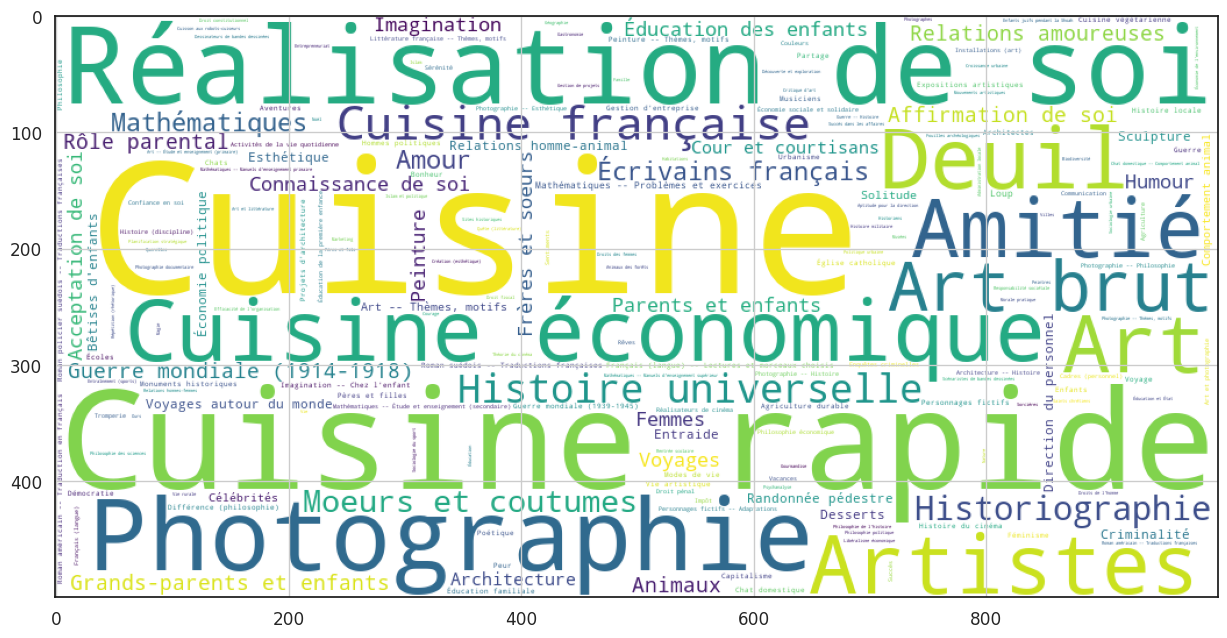

In [13]:
# Get list of chaines
plot_wordcloud(
    chaines,
    backgound_color="white",
    figsize=(15, 8),
    width=1000,
    height=500,
    save_file="wordcloud_embeddings_chaines.png",
)

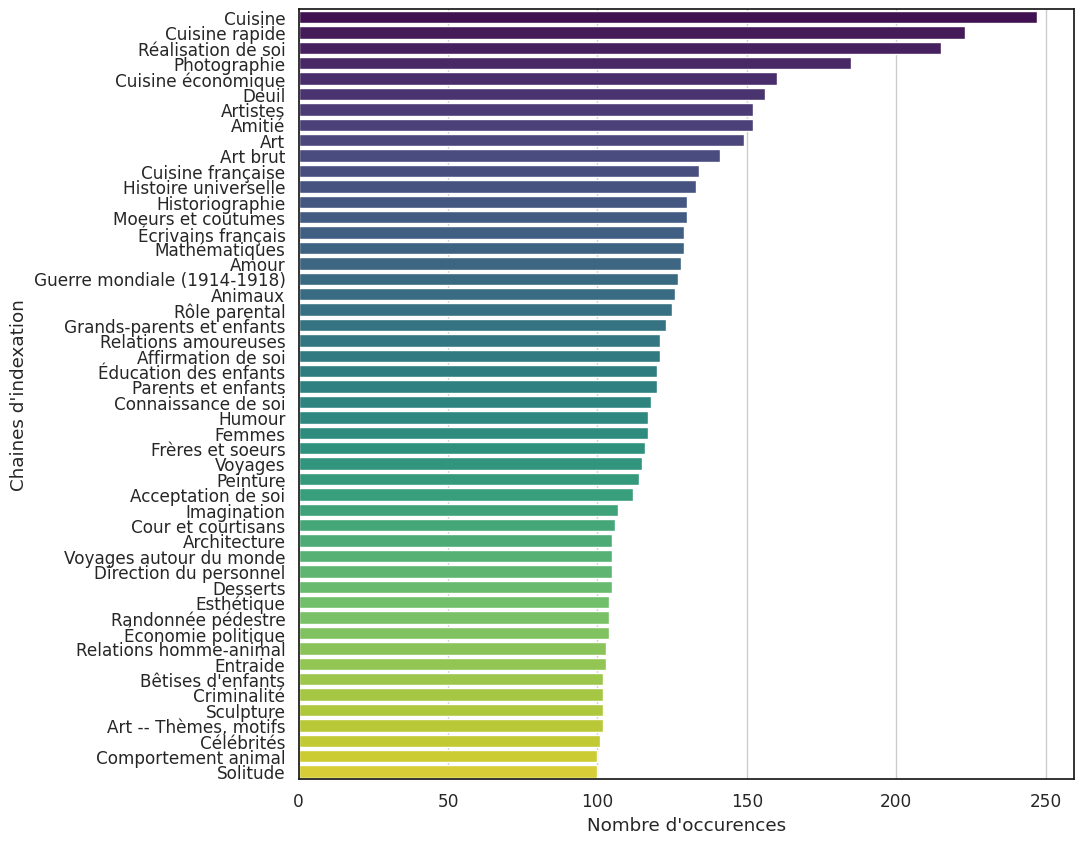

In [14]:
# Barplot of indexation chains
plot_barplot_of_tags(chaines, nb_of_tags=50, ylabel="Chaines d'indexation", figsize=(10,10))

In [15]:
# check that all labels belongs to rameau
# Verification que toutes les vedettes appartiennent au referenciel RAMEAU
check_rameau_concepts(keywords, savefile=os.path.join(data_path, "concepts_a_verifier_embeddingfile_juin2023.txt"))

Tous les mots clés sont des concepts rameau


## Compute all labels for all notices

In [16]:
chains_emb_test = pd.DataFrame(emb_test.groupby("PPN")["embedding_chains"].apply(lambda x: list(x))).reset_index()
chains_emb_test

PPN                                   embedding_chains
0      00002564X  [Innovation -- Philosophie, Innovation -- Aspe...
1      000057525  [Mathématiques économiques, Économétrie, Modèl...
2      000079472  [Pétrole, Gisements pétrolifères, Pétrole -- I...
3      000085642  [Magie -- Histoire, Magie chrétienne, Magie an...
4      000087637  [Français (langue) -- Morphologie (linguistiqu...
...          ...                                                ...
29239  268996237  [Microorganismes, Bactéries, Microbiologie, Di...
29240  268996970  [Mangas -- Traductions françaises, Mères et en...
29241  268998078  [Rentrée scolaire, Jeux d'extérieur, Écoles ma...
29242  268998485  [Méthode Montessori, Activités d'éveil (premiè...
29243  268998663  [Littérature et société, Politique et littérat...

[29244 rows x 2 columns]

In [17]:
# Compute list of RAMEAU concepts present in each embedding chains
emb_concepts = pd.DataFrame(emb_test.groupby("PPN")["embeddings_autorites"].apply(lambda x: flatten(list(x)))).reset_index()
chains_emb_test = chains_emb_test.merge(emb_concepts)
chains_emb_test.head(5)

PPN                                   embedding_chains   
0  00002564X  [Innovation -- Philosophie, Innovation -- Aspe...  \
1  000057525  [Mathématiques économiques, Économétrie, Modèl...   
2  000079472  [Pétrole, Gisements pétrolifères, Pétrole -- I...   
3  000085642  [Magie -- Histoire, Magie chrétienne, Magie an...   
4  000087637  [Français (langue) -- Morphologie (linguistiqu...   

                                embeddings_autorites  
0  [Innovation, Philosophie, Innovation, Aspect s...  
1  [Mathématiques économiques, Économétrie, Modèl...  
2  [Pétrole, Gisements pétrolifères, Pétrole, Ind...  
3  [Magie, Histoire, Magie chrétienne, Magie anti...  
4  [Français (langue), Morphologie (linguistique)...

In [18]:
# Check types
print(type(chains_emb_test.loc[0, "embedding_chains"]), type(chains_emb_test.loc[0, "embeddings_autorites"]))

<class 'list'> <class 'list'>


## Same process for valid test

Le dataset contient: 
 - 558 autorités RAMEAU differentes 
 - 578 chaines d'indexation différentes


Tous les mots clés sont des concepts rameau


PPN                                   embedding_chains   
0  000308838  [État, Administration publique, Fonctionnaires...  \
1  00094758X  [Dollar américain, Système monétaire internati...   
2  003632806  [Intellectuels -- Activité politique, Intellec...   
3  047450037  [Bouddhisme -- Anthologies, Bouddhisme -- Livr...   
4  05224170X  [Professeurs de sciences de l'éducation, Appre...   

                                embeddings_autorites  
0  [État, Administration publique, Fonctionnaires...  
1  [Dollar américain, Système monétaire internati...  
2  [Intellectuels, Activité politique, Intellectu...  
3  [Bouddhisme, Anthologies, Bouddhisme, Livres s...  
4  [Professeurs de sciences de l'éducation, Appre...

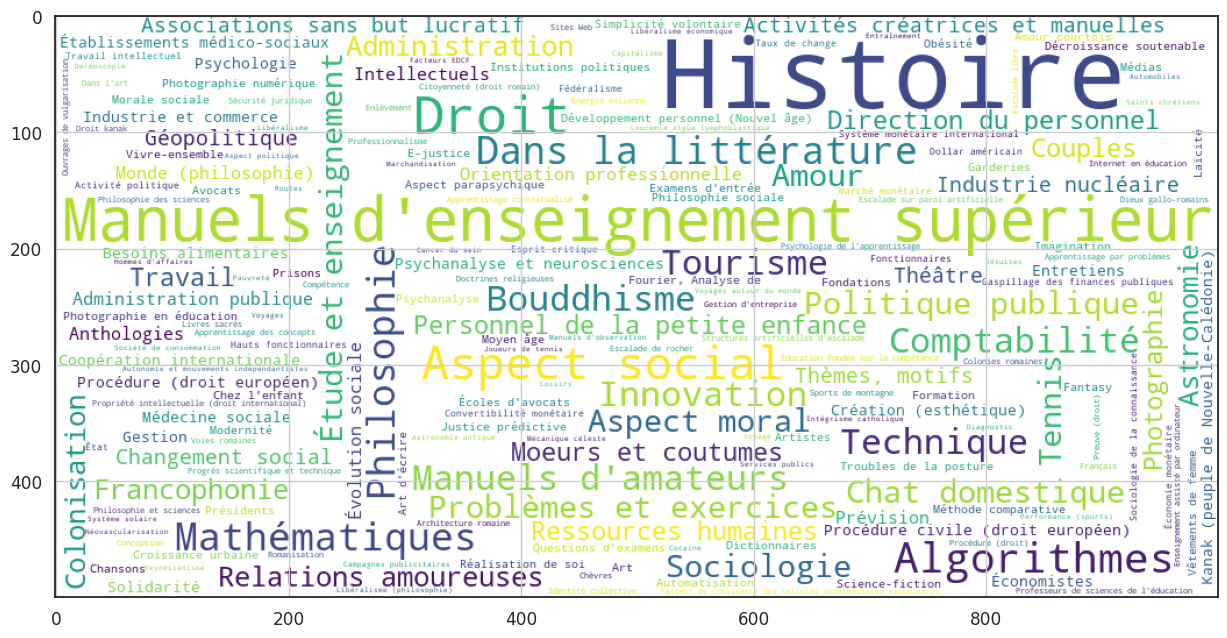

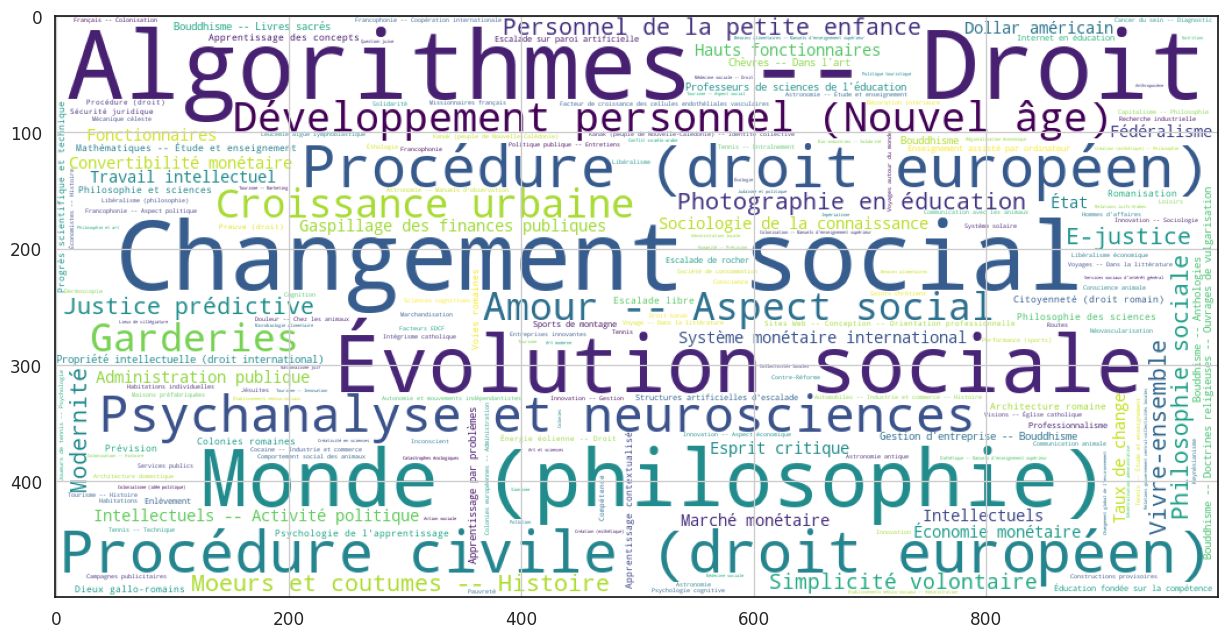

In [19]:
# Check import for embeddings
emb_valid = pd.read_csv(
    os.path.join(data_path_embed, embedding_100notices))
emb_valid = emb_valid.dropna()
emb_valid.rename(columns={"ppn" : "PPN", "label": "embedding_chains"}, inplace=True)
emb_valid["embeddings_autorites"] = emb_valid["embedding_chains"].apply(lambda x: x.split(" -- "))
keywords_valid = flatten(emb_valid["embeddings_autorites"])
chaines_valid = emb_valid["embedding_chains"]
print(f"Le dataset contient: \n - {len(set(keywords_valid))} autorités RAMEAU differentes \n - {len(chaines_valid.unique())} chaines d'indexation différentes")

# Get list of labels
plot_wordcloud(
    keywords_valid,
    backgound_color="white",
    figsize=(15, 8),
    width=1000,
    height=500,
    save_file="wordcloud_embeddings_autorites_validation_dataset.png",
)
# Get list of chaines
plot_wordcloud(
    chaines_valid,
    backgound_color="white",
    figsize=(15, 8),
    width=1000,
    height=500,
    save_file="wordcloud_embeddings_chaines_validation_dataset.png",
)

# Verification que toutes les vedettes appartiennent au referenciel RAMEAU
check_rameau_concepts(keywords_valid, savefile=os.path.join(data_path, "concepts_a_verifier_embeddingfile_valid100_juin2023.txt"))

# Creation du dataframe
chains_emb_valid = pd.DataFrame(emb_valid.groupby("PPN")["embedding_chains"].apply(lambda x: list(x))).reset_index()
val_concepts = pd.DataFrame(emb_valid.groupby("PPN")["embeddings_autorites"].apply(lambda x: flatten(list(x)))).reset_index()
chains_emb_valid = chains_emb_valid.merge(val_concepts)
chains_emb_valid.head(5)

In [20]:
# Check types
print(type(chains_emb_test.loc[0, "embedding_chains"]), type(chains_emb_valid.loc[0, "embeddings_autorites"]))

<class 'list'> <class 'list'>


## Merge Sudoc et embeddings

In [21]:
# Check notices extraction on test data
test = df_test.merge(chains_emb_test, on="PPN", how="inner")
print("Dimension after merge: ", test.shape)
test.to_pickle(os.path.join(data_path,"test_dataset_embeddings_results.pkl"))
test.head()

Dimension after merge:  (29227, 12)


PPN                                              TITRE   
0  00002564X                          La révolution structurale  \
1  000057525  La théorie des jeux et ses applications à l'éc...   
2  000079472                          Pétrole : le vrai dossier   
3  000085642        Magie : aspects de la tradition occidentale   
4  000087637          Mathématiques de base pour les linguistes   

                                              RESUME   
0  Mutations ou crises, les brusques accès de fiè...  \
1  La théorie des jeux occupe au sein des mathéma...   
2  Que dissimulent les événements que nous avons ...   
3  La magie se situe au cœur de la tradition occu...   
4  La fonction essentielle de ce livre est de fai...   

                                              RAMEAU  DEWEY   
0                                     Structuralisme    100  \
1         Mathématiques économiques;Théorie des jeux  519.3   
2                            Crise économique (1973)    320   
3                                              Magie    100   
4  Linguistique -- Méthodes graphiques;Linguistiq...    510   

                                               DESCR   
0  La révolution structurale Mutations ou crises,...  \
1  La théorie des jeux et ses applications à l'éc...   
2  Pétrole : le vrai dossier Que dissimulent les ...   
3  Magie : aspects de la tradition occidentale La...   
4  Mathématiques de base pour les linguistes La f...   

                                      RAMEAU_CHECKED   
0                                     Structuralisme  \
1         Mathématiques économiques;Théorie des jeux   
2                            Crise économique (1973)   
3                                              Magie   
4  Linguistique -- Méthodes graphiques;Linguistiq...   

   presence_chaine_indexation   
0                       False  \
1                       False   
2                       False   
3                       False   
4                        True   

                                rameau_chaines_index   
0                                 ['Structuralisme']  \
1  ['Mathématiques économiques', 'Théorie des jeux']   
2                        ['Crise économique (1973)']   
3                                          ['Magie']   
4  ['Linguistique -- Méthodes graphiques', 'Lingu...   

                                     rameau_concepts   
0                                 ['Structuralisme']  \
1  ['Mathématiques économiques', 'Théorie des jeux']   
2                        ['Crise économique (1973)']   
3                                          ['Magie']   
4  ['Linguistique', 'Méthodes graphiques', 'Lingu...   

                                    embedding_chains   
0  [Innovation -- Philosophie, Innovation -- Aspe...  \
1  [Mathématiques économiques, Économétrie, Modèl...   
2  [Pétrole, Gisements pétrolifères, Pétrole -- I...   
3  [Magie -- Histoire, Magie chrétienne, Magie an...   
4  [Français (langue) -- Morphologie (linguistiqu...   

                                embeddings_autorites  
0  [Innovation, Philosophie, Innovation, Aspect s...  
1  [Mathématiques économiques, Économétrie, Modèl...  
2  [Pétrole, Gisements pétrolifères, Pétrole, Ind...  
3  [Magie, Histoire, Magie chrétienne, Magie anti...  
4  [Français (langue), Morphologie (linguistique)...

In [22]:
# Check types
print(type(test.loc[0, "embedding_chains"]), type(test.loc[0, "embeddings_autorites"]))

<class 'list'> <class 'list'>


In [23]:
# On validation data
valid = df_valid.merge(chains_emb_valid, on="PPN", how="inner")
print("Dimension after merge: ", valid.shape)
valid.head()

Dimension after merge:  (100, 12)


PPN                                              TITRE   
0  000308838  Les sommets de l'État : essai sur l'élite du p...  \
1  00094758X                                          Le dollar   
2  003632806  Les intellectuels sous la Ve République : 1958...   
3  047450037                                Bouddha, bouddhisme   
4  05224170X  Apprendre à aimer les mathématiques : conditio...   

                                              RESUME   
0  u XIXe siècle à nos jours, l'Etat "fort" à la ...  \
1  La quatrième de couverture indique : "Quelle e...   
2  Célèbres, influents, on les voit, on en parle ...   
3  La 4e de couv. indique : "Ce petit livre répon...   
4  Les entretiens d'élèves et d'enseignants, anal...   

                                              RAMEAU  DEWEY   
0  Bureaucratie;Classes dirigeantes;Classes dirig...    NaN  \
1  Dollar américain;Finances internationales;Poli...    320   
2               Intellectuels;Intellectuels français    301   
3                                         Bouddhisme  294.3   
4  Mathématiques -- Étude et enseignement -- Aspe...    370   

                                               DESCR   
0  Les sommets de l'État : essai sur l'élite du p...  \
1  Le dollar La quatrième de couverture indique :...   
2  Les intellectuels sous la Ve République : 1958...   
3  Bouddha, bouddhisme La 4e de couv. indique : "...   
4  Apprendre à aimer les mathématiques : conditio...   

                                      RAMEAU_CHECKED   
0  Bureaucratie;Classes dirigeantes;Classes dirig...  \
1  Dollar américain;Finances internationales;Poli...   
2               Intellectuels;Intellectuels français   
3                                         Bouddhisme   
4  Mathématiques -- Étude et enseignement;Mathéma...   

   presence_chaine_indexation   
0                       False  \
1                       False   
2                       False   
3                       False   
4                        True   

                                rameau_chaines_index   
0  ['Bureaucratie', 'Classes dirigeantes', 'Class...  \
1  ['Dollar américain', 'Finances internationales...   
2        ['Intellectuels', 'Intellectuels français']   
3                                     ['Bouddhisme']   
4  ['Mathématiques -- Étude et enseignement', 'Ma...   

                                     rameau_concepts   
0  ['Bureaucratie', 'Classes dirigeantes', 'Class...  \
1  ['Dollar américain', 'Finances internationales...   
2        ['Intellectuels', 'Intellectuels français']   
3                                     ['Bouddhisme']   
4  ['Mathématiques', 'Étude et enseignement', 'Ma...   

                                    embedding_chains   
0  [État, Administration publique, Fonctionnaires...  \
1  [Dollar américain, Système monétaire internati...   
2  [Intellectuels -- Activité politique, Intellec...   
3  [Bouddhisme -- Anthologies, Bouddhisme -- Livr...   
4  [Professeurs de sciences de l'éducation, Appre...   

                                embeddings_autorites  
0  [État, Administration publique, Fonctionnaires...  
1  [Dollar américain, Système monétaire internati...  
2  [Intellectuels, Activité politique, Intellectu...  
3  [Bouddhisme, Anthologies, Bouddhisme, Livres s...  
4  [Professeurs de sciences de l'éducation, Appre...

In [24]:
# Check types
print(type(valid.loc[0, "embedding_chains"]), type(valid.loc[0, "embeddings_autorites"]))

<class 'list'> <class 'list'>


In [25]:
# Save file
valid.to_pickle(os.path.join(data_path,"valid100_dataset_embeddings_results.pkl"))

## Multilabel classification 

### Create binarizer

#### From indexation chains

In [26]:
# Import origianl data
orig = pd.read_pickle(os.path.join(data_path, "working_data_sans_dewey.pkl"))
print("Original dataset: ", orig.shape)
orig.head(3)

Original dataset:  (154447, 10)


PPN                                              TITRE   
0  000002364                              La culture pour vivre  \
1  000014877  La nuit, le jour : essai psychanalytique sur l...   
2  000021857                                 Ruptures, cultures   

                                              RESUME   
0  Mort de la culture populaire en France. Mutati...  \
1  Discontinuité, latence, rétablissement d’une c...   
2  Il faut imaginer Robinson sur son île, au mome...   

                                              RAMEAU   DEWEY   
0  Culture populaire;Diffusion de la culture;Poli...     840  \
1          Complexe de castration;Psychanalyse;Rêves  154.63   
2                                            Culture     840   

                                               DESCR   
0  La culture pour vivre Mort de la culture popul...  \
1  La nuit, le jour : essai psychanalytique sur l...   
2  Ruptures, cultures Il faut imaginer Robinson s...   

                                      RAMEAU_CHECKED   
0  Culture populaire;Diffusion de la culture;Poli...  \
1          Complexe de castration;Psychanalyse;Rêves   
2                                            Culture   

   presence_chaine_indexation   
0                       False  \
1                       False   
2                       False   

                                rameau_chaines_index   
0  [Culture populaire, Diffusion de la culture, P...  \
1      [Complexe de castration, Psychanalyse, Rêves]   
2                                          [Culture]   

                                     rameau_concepts  
0  [Culture populaire, Diffusion de la culture, P...  
1      [Complexe de castration, Psychanalyse, Rêves]  
2                                          [Culture]

In [27]:
# Create chaines_binarizer
chaines_orig = flatten(orig["rameau_chaines_index"])
chaines_orig = set(chaines_orig)
print(f"Il y a {len(chaines_orig)} chaines d'indexation différentes dans le jeu d'entrainement")

Il y a 68705 chaines d'indexation différentes dans le jeu d'entrainement


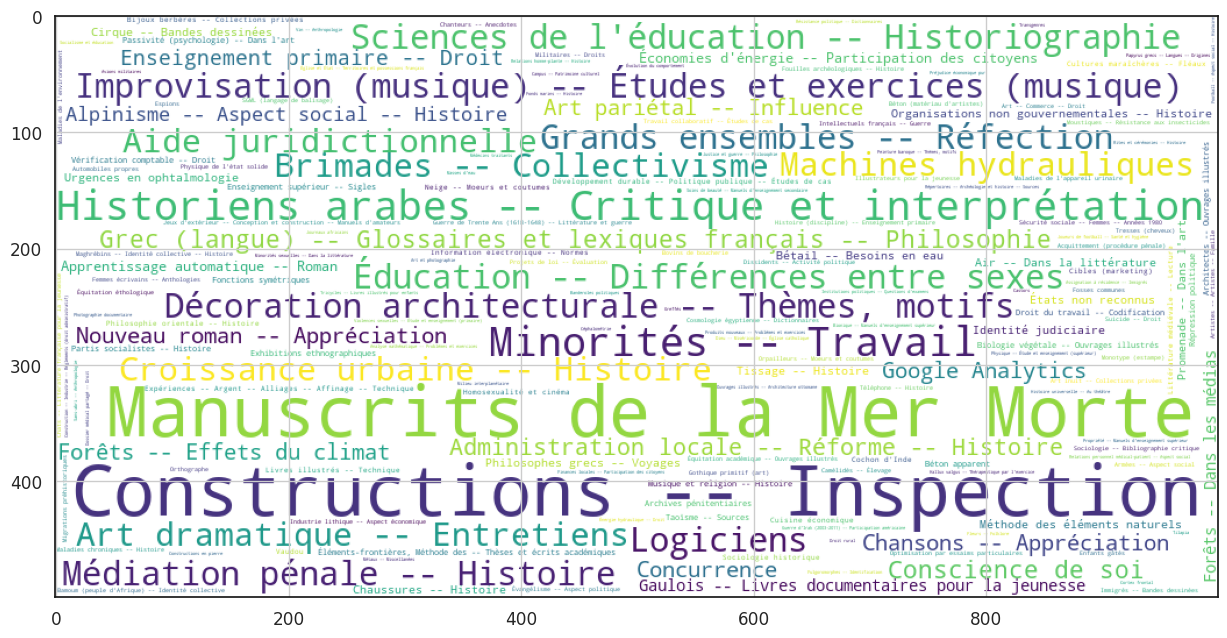

In [28]:
plot_wordcloud(
    chaines_orig,
    backgound_color="white",
    figsize=(15, 8),
    width=1000,
    height=500,
)

In [29]:
# Multilabel binarizer
mlb_chains = MultiLabelBinarizer(sparse_output=True)
mlb_chains.fit([chaines_orig])

MultiLabelBinarizer(sparse_output=True)

In [30]:
# Check classes
print("Nombre de classes: ", len(mlb_chains.classes_))
print("\nExemples : \n", mlb_chains.classes_[0:10])

Nombre de classes:  68705

Exemples : 
 ['' "'Ndrangheta" "'Ūd, Musique d' -- Histoire"
 '10 et 11 janvier 2015, Manifestations des (France)'
 '10 et 11 janvier 2015, Manifestations des (France) -- Aspect social'
 '11 septembre 2001, Attentats du (États-Unis)'
 '11 septembre 2001, Attentats du (États-Unis) -- Bandes dessinées'
 '11 septembre 2001, Attentats du (États-Unis) -- Influence'
 '11 septembre 2001, Attentats du (États-Unis) -- Roman'
 '11 septembre 2001, Attentats du (États-Unis) -- Terrorisme']


#### From concepts

In [31]:
# Create chaines_binarizer
concepts_orig = ram["NOM"]
print(f"Il y a {len(set(concepts_orig))} concepts RAMEAU possibles")

Il y a 103021 concepts RAMEAU possibles


In [32]:
# Multilabel binarizer
mlb_concepts = MultiLabelBinarizer(sparse_output=True)
mlb_concepts.fit([concepts_orig])

MultiLabelBinarizer(sparse_output=True)

In [33]:
# Check binarization
print("Nombre de concepts: ", len(mlb_concepts.classes_))
print("\nExemples : \n", mlb_concepts.classes_[10:20])

Nombre de concepts:  103021

Exemples : 
 ["'Au ni mako" "'Au ni mako, Musique de" "'Au paina"
 "'Au paina, Musique d'" "'Au porare" "'Au porare, Musique d'"
 "'Au tahana" "'Au tahana, Musique d'" "'Au taka\x91iori"
 "'Au taka‘iori, Musique d'"]


### Metrics on Test Set

#### Binarize Sudoc indexation chains and embeddings chains

In [34]:
# Binarization on sudoc chains
sudoc = mlb_chains.transform(test["rameau_chaines_index"].apply(lambda x: eval(x)))
# Check classes
mlb_chains.inverse_transform(sudoc[20:25])

/home/aurelie/anaconda3/envs/abes_index/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Aspect symbolique', 'Contes détournés', 'Parodies et pastiches'] will be ignored
  warnings.warn(


[('Géologie',),
 ('Femmes terroristes -- Histoire', 'Terrorisme -- Histoire'),
 ("Imagination -- Chez l'enfant", 'Poésie et enfants'),
 ('Son -- Histoire', 'Pollution par le bruit', 'Psychoacoustique'),
 ('Armes nucléaires', 'Énergie nucléaire -- Histoire', 'Politique nucléaire')]

In [35]:
# Binarization on embedding chains
embed = mlb_chains.transform(test["embedding_chains"])
# Check classes
mlb_chains.inverse_transform(embed[20:25])

/home/aurelie/anaconda3/envs/abes_index/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['Antennes-relais de  téléphonie mobile', 'Contes détournés', 'Parodies et pastiches', 'Vie en mer -- Descriptions et voyages'] will be ignored
  warnings.warn(


[('Patrimoine géologique',
  'Géomorphologie',
  'Géologie -- Étude et enseignement (primaire)',
  'Géoarchéologie',
  'Géographie physique',
  'Géologie'),
 ('Femmes révolutionnaires',
  'Anarchisme',
  'Militants politiques',
  'Anarchistes',
  'Militantes politiques',
  'Socialisme'),
 ("Dévotion à l'Enfant Jésus",
  'Enfants -- Dans la littérature',
  'Nature -- Poésie',
  'Enfants -- Poésie pour la jeunesse',
  'Poésie et enfants',
  "Réalité -- Chez l'enfant"),
 ('Paysannerie',
  'Agriculteurs',
  'Aménagement du paysage',
  'Paysage -- Philosophie',
  'Classe ouvrière',
  'Paysage'),
 ('Désarmement nucléaire',
  'Politique nucléaire',
  'Énergie nucléaire',
  'Armes nucléaires',
  'Armes nucléaires -- Histoire',
  'Radioactivité -- Histoire')]

#### Binarize Sudoc concepts and embedding concepts

In [36]:
# Binarization on sudoc chains
sudoc_concepts = mlb_concepts.transform(test["rameau_concepts"].apply(lambda x: eval(x)))
# Check classes
mlb_concepts.inverse_transform(sudoc_concepts[20:25])

/home/aurelie/anaconda3/envs/abes_index/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) ['', 'La  Femme adultère (épisode biblique)', 'La  Tour de Babel (épisode biblique)', 'Le  Chat botté (conte)', 'Le  Français (goélette)', 'Le  Petit Chaperon rouge (conte)', "Les  Disciples d'Emmaüs (épisode biblique)", 'Les  Trois Grâces (art)'] will be ignored
  warnings.warn(


[('Géologie',),
 ('Terrorisme', 'Histoire', 'Femmes terroristes'),
 ('Poésie et enfants', 'Imagination', "Chez l'enfant"),
 ('Son', 'Pollution par le bruit', 'Histoire', 'Psychoacoustique'),
 ('Histoire', 'Énergie nucléaire', 'Politique nucléaire', 'Armes nucléaires')]

In [37]:
# Binarization on embedding chains
embed_concepts = mlb_concepts.transform(test["embeddings_autorites"])
# Check classes
mlb_concepts.inverse_transform(embed_concepts[20:25])

[('Patrimoine géologique',
  'Géographie physique',
  'Géomorphologie',
  'Géologie',
  'Étude et enseignement (primaire)',
  'Géoarchéologie'),
 ('Anarchistes',
  'Militants politiques',
  'Femmes révolutionnaires',
  'Socialisme',
  'Anarchisme',
  'Militantes politiques'),
 ('Réalité',
  'Poésie et enfants',
  'Nature',
  'Poésie pour la jeunesse',
  'Dans la littérature',
  "Dévotion à l'Enfant Jésus",
  'Enfants',
  'Poésie',
  "Chez l'enfant"),
 ('Agriculteurs',
  'Paysage',
  'Philosophie',
  'Aménagement du paysage',
  'Paysannerie',
  'Classe ouvrière'),
 ('Énergie nucléaire',
  'Politique nucléaire',
  'Histoire',
  'Radioactivité',
  'Désarmement nucléaire',
  'Armes nucléaires')]

In [38]:
# Compute metrics
results = dict()
results["Embeddings_rameau_concepts"] = label_metrics_report("Embeddings", sudoc_concepts, embed_concepts, zero_division=0)
results["Embeddings_chaines_indexation"] = label_metrics_report("Embeddings", sudoc, embed, zero_division=0)

### Dataframe of results

In [39]:
result_df = pd.DataFrame(results).T
result_df

Hamming Loss Brier Loss  Accuracy   
Embeddings_rameau_concepts        0.000072        NaN  0.000445  \
Embeddings_chaines_indexation     0.000101        NaN  0.000103   

                              Precision - Macro Recall - Macro   
Embeddings_rameau_concepts              0.01904       0.036533  \
Embeddings_chaines_indexation          0.036906       0.072207   

                              F1_Score - Macro Jaccard - Macro   
Embeddings_rameau_concepts            0.022329        0.015859  \
Embeddings_chaines_indexation         0.043183        0.032614   

                              Precision - Weighted Recall - Weighted   
Embeddings_rameau_concepts                0.198188          0.380796  \
Embeddings_chaines_indexation             0.161313          0.290904   

                              F1_Score - Weighted Jaccard - Weighted   
Embeddings_rameau_concepts               0.242639           0.153731  \
Embeddings_chaines_indexation            0.187406           0.122964   

                              Precision - Sample Recall - Sample   
Embeddings_rameau_concepts              0.152657        0.421183  \
Embeddings_chaines_indexation           0.107608        0.331107   

                              F1_Score - Sample Jaccard - Sample   
Embeddings_rameau_concepts             0.210702         0.132534  \
Embeddings_chaines_indexation          0.153419         0.093934   

                                                                       Precision   
Embeddings_rameau_concepts     {'Macro': 0.019039595419410547, 'Micro': 0.149...  \
Embeddings_chaines_indexation  {'Macro': 0.036905759706191164, 'Micro': 0.107...   

                                                                          Recall   
Embeddings_rameau_concepts     {'Macro': 0.03653345908236214, 'Micro': 0.3807...  \
Embeddings_chaines_indexation  {'Macro': 0.07220720452081716, 'Micro': 0.2909...   

                                                                      F1-measure   
Embeddings_rameau_concepts     {'Macro': 0.022328995452450845, 'Micro': 0.215...  \
Embeddings_chaines_indexation  {'Macro': 0.04318314572575639, 'Micro': 0.1571...   

                                                                         Jaccard  
Embeddings_rameau_concepts     {'Macro': 0.015859141921171913, 'Micro': 0.120...  
Embeddings_chaines_indexation  {'Macro': 0.03261418162665872, 'Micro': 0.0852...

### Plot

In [40]:
# Plot results
metrics=[
        "Precision - Sample",
        "Recall - Sample",
        "F1_Score - Sample",
        "Jaccard - Sample",
        "Precision - Weighted",
        "Recall - Weighted",
        "F1_Score - Weighted",
        "Jaccard - Weighted",
    ]
metrics_radar_plot(
    result_df,
    remove_identity=False,
    metrics=metrics,
    title="Comparaison SUDOC - Embeddings - June 2023 - Test set",
    savefig="metrics_embeddings-sudoc_test_dataset.html",)

## Multilabel classification - Metrics on Validation Set

In [41]:
# Check that validation file is already on test file
all(valid["PPN"].isin(df_test["PPN"]))

True

In [42]:
# Select indexes to keep
valid_index = df_test[df_test["PPN"].isin(valid["PPN"])].index
len(valid_index)

100

In [43]:
# Binarization
sudoc_val = mlb_chains.transform(test.loc[valid_index, "rameau_chaines_index"].apply(lambda x: eval(x)))
embed_val = mlb_chains.transform(test.loc[valid_index, "embedding_chains"])
sudoc_concepts_val = mlb_concepts.transform(test.loc[valid_index, "rameau_concepts"].apply(lambda x: eval(x)))
embed_concepts_val = mlb_concepts.transform(test.loc[valid_index, "embeddings_autorites"])

In [44]:
# Compute metrics
results_valid = dict()
results_valid["Embeddings_rameau_concepts"] = label_metrics_report("Embeddings", sudoc_concepts_val, embed_concepts_val, zero_division=0)
results_valid["Embeddings_chaines_indexation"] = label_metrics_report("Embeddings", sudoc_val, embed_val, zero_division=0)

In [45]:
# Transform into dataframe
result_valid = pd.DataFrame(results_valid).T
result_valid

Hamming Loss Brier Loss Accuracy   
Embeddings_rameau_concepts        0.000071        NaN      0.0  \
Embeddings_chaines_indexation       0.0001        NaN      0.0   

                              Precision - Macro Recall - Macro   
Embeddings_rameau_concepts             0.000862       0.000926  \
Embeddings_chaines_indexation          0.001004       0.001019   

                              F1_Score - Macro Jaccard - Macro   
Embeddings_rameau_concepts            0.000864        0.000818  \
Embeddings_chaines_indexation         0.001004         0.00099   

                              Precision - Weighted Recall - Weighted   
Embeddings_rameau_concepts                0.381024          0.395604  \
Embeddings_chaines_indexation             0.307692          0.307692   

                              F1_Score - Weighted Jaccard - Weighted   
Embeddings_rameau_concepts               0.371886           0.343457  \
Embeddings_chaines_indexation            0.304843           0.299145   

                              Precision - Sample Recall - Sample   
Embeddings_rameau_concepts              0.161802        0.460119  \
Embeddings_chaines_indexation               0.12        0.342857   

                              F1_Score - Sample Jaccard - Sample   
Embeddings_rameau_concepts             0.221255         0.139744  \
Embeddings_chaines_indexation          0.164517         0.102966   

                                                                       Precision   
Embeddings_rameau_concepts     {'Macro': 0.0008619062564374684, 'Micro': 0.16...  \
Embeddings_chaines_indexation  {'Macro': 0.0010042937195255076, 'Micro': 0.12...   

                                                                          Recall   
Embeddings_rameau_concepts     {'Macro': 0.0009260710137230458, 'Micro': 0.39...  \
Embeddings_chaines_indexation  {'Macro': 0.0010188487009679063, 'Micro': 0.30...   

                                                                      F1-measure   
Embeddings_rameau_concepts     {'Macro': 0.0008636255993590906, 'Micro': 0.22...  \
Embeddings_chaines_indexation  {'Macro': 0.0010042937195255076, 'Micro': 0.17...   

                                                                         Jaccard  
Embeddings_rameau_concepts     {'Macro': 0.000818468510735136, 'Micro': 0.129...  
Embeddings_chaines_indexation  {'Macro': 0.000989738738083109, 'Micro': 0.094...

In [46]:
# Plot results
metrics_radar_plot(
    result_valid,
    remove_identity=False,
    metrics=metrics,
    title="Comparaison SUDOC - Embeddings - June 2023 - Validation set",
    savefig="metrics_embeddings-sudoc_validation_dataset.html",)